In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [3]:
#read temperature data
temp_path=r"..\data\historical_temperatures.csv"
temperatures = pd.read_csv(temp_path, usecols=range(4))
temperatures['del_date'] = pd.to_datetime(temperatures['del_date'])
temperatures['he'] = temperatures['he'].astype(int)
temperatures['hour'] = temperatures['he'] - 1
temperatures['timestamp'] = temperatures['del_date'] + pd.to_timedelta(temperatures['hour'], unit='h')
temperatures.drop(['del_date', 'he', 'hour'], axis=1, inplace=True)
temperatures.head()

,temp,location,timestamp
0,-28.1,CYEG,2018-01-01 00:00:00+00:00
1,-28.3,CYEG,2018-01-01 01:00:00+00:00
2,-28.7,CYEG,2018-01-01 02:00:00+00:00
3,-28.5,CYEG,2018-01-01 03:00:00+00:00
4,-28.3,CYEG,2018-01-01 04:00:00+00:00


In [4]:
#set 'timestamp' as datetime index
temperatures.set_index('timestamp', inplace=True)
temperatures.index = pd.to_datetime(temperatures.index)
temperatures.sort_index(inplace=True)

# Pivot the temperature data
# Use 'timestamp' as index, 'location' as columns, and 'temp' as values
pivoted_temperatures = temperatures.pivot_table(index='timestamp', columns='location', values='temp')

# Rename the columns for clarity
pivoted_temperatures.columns = ['CYEG_temp', 'CYYC_temp']

In [5]:
# Create a full datetime index from the start to the end of the data at hourly frequency
full_time_index = pd.date_range(start=temperatures.index.min(),
                                end=temperatures.index.max(),
                                freq='H')
# Convert full_time_index to a DataFrame to merge temp data
full_time_df = pd.DataFrame(index=full_time_index)
full_time_df.index.name = 'timestamp'
# Merge temp data with the full time index
temp_data = full_time_df.merge(pivoted_temperatures, left_index=True, right_index=True, how='left')
temp_data.head()

C:\Users\cb44a\AppData\Local\Temp\ipykernel_9008\3628361503.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_index = pd.date_range(start=temperatures.index.min(),


,CYEG_temp,CYYC_temp
timestamp,,
2018-01-01 00:00:00+00:00,-28.1,-28.1
2018-01-01 01:00:00+00:00,-28.3,-28.6
2018-01-01 02:00:00+00:00,-28.7,-29.1
2018-01-01 03:00:00+00:00,-28.5,-30.0
2018-01-01 04:00:00+00:00,-28.3,-27.6


In [6]:
#null values in temp
temp_data.isnull().sum()

CYEG_temp    0
CYYC_temp    0
dtype: int64

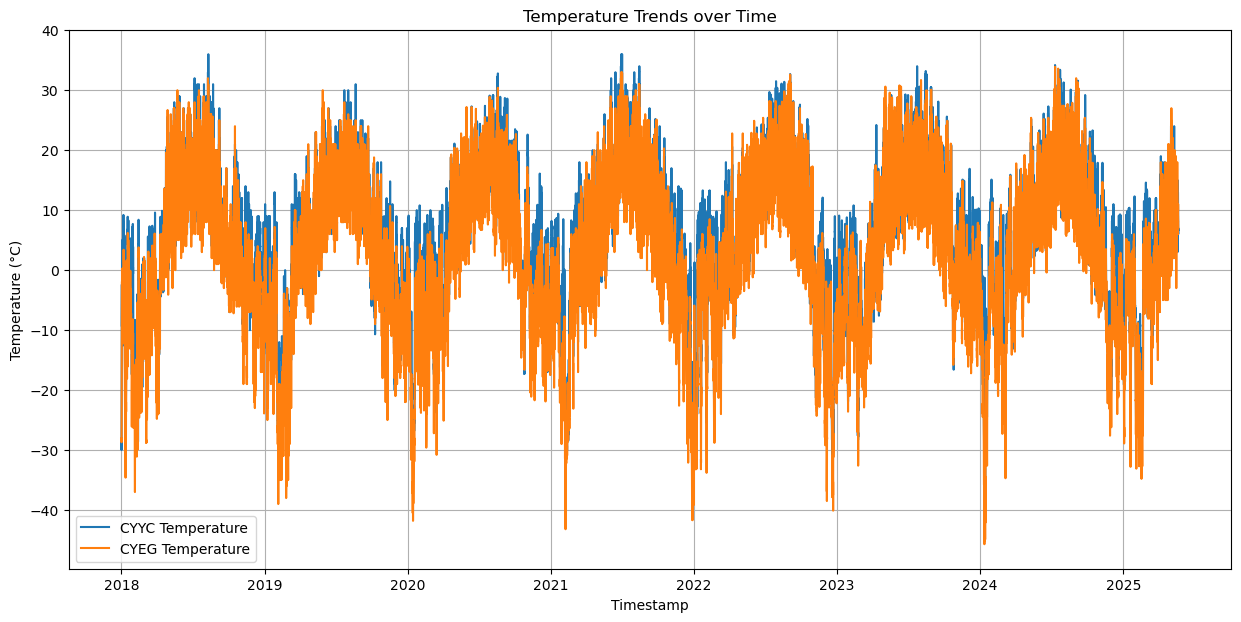

In [7]:
import matplotlib.pyplot as plt
# Visualize temperature trends
plt.figure(figsize=(15, 7))
plt.plot(temp_data.index, temp_data['CYYC_temp'], label='CYYC Temperature')
plt.plot(temp_data.index, temp_data['CYEG_temp'], label='CYEG Temperature')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Trends over Time')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
## Create temperature related other features
#create average temp
temp_data['Avg_temp']=(temp_data['CYEG_temp']+temp_data['CYYC_temp'])/2

# Calculate Heating Degree Hours (HDH) & Cooling Degree Hours (CDH)
# Define the base temperature
base_temperature = 18
# If Avg_temp is below base_temperature, calculate the difference, otherwise 0
temp_data['HDH'] = np.maximum(0, base_temperature - temp_data['Avg_temp'])
# If Avg_temp is above base_temperature, calculate the difference, otherwise 0
temp_data['CDH'] = np.maximum(0, temp_data['Avg_temp'] - base_temperature)
temp_data.head()

,CYEG_temp,CYYC_temp,Avg_temp,HDH,CDH
timestamp,,,,,
2018-01-01 00:00:00+00:00,-28.1,-28.1,-28.10,46.10,0.0
2018-01-01 01:00:00+00:00,-28.3,-28.6,-28.45,46.45,0.0
2018-01-01 02:00:00+00:00,-28.7,-29.1,-28.90,46.90,0.0
2018-01-01 03:00:00+00:00,-28.5,-30.0,-29.25,47.25,0.0
2018-01-01 04:00:00+00:00,-28.3,-27.6,-27.95,45.95,0.0


In [9]:
######################### Population estimation from the pdf document ########################################
years = list(range(2018, 2027))
population_millions = [4.33, 4.37, 4.39, 4.42, 4.54, 4.73, 4.95, 5.07, 5.19]
population_df = pd.DataFrame({
    'year': years,
    'Population_Millions': population_millions
})
population_df

,year,Population_Millions
0,2018,4.33
1,2019,4.37
2,2020,4.39
3,2021,4.42
4,2022,4.54
5,2023,4.73
6,2024,4.95
7,2025,5.07
8,2026,5.19


In [10]:
demand_path=r"..\data\historical_demand.csv"
demand=pd.read_csv(demand_path)
demand['del_date'] = pd.to_datetime(demand['del_date'])
demand['he'] = demand['he'].astype(int)
demand['hour'] = demand['he'] - 1
demand['timestamp'] = demand['del_date'] + pd.to_timedelta(demand['hour'], unit='h')
demand.drop(['del_date', 'he', 'hour'], axis=1, inplace=True)
demand

,system_demand,timestamp
0,10221,2018-01-01 00:00:00+00:00
1,10082,2018-01-01 01:00:00+00:00
2,9949,2018-01-01 02:00:00+00:00
3,9886,2018-01-01 03:00:00+00:00
4,9930,2018-01-01 04:00:00+00:00
...,...,...
64718,8647,2025-05-21 04:00:00+00:00
64719,8768,2025-05-21 05:00:00+00:00
64720,9105,2025-05-21 06:00:00+00:00
64721,9520,2025-05-21 07:00:00+00:00


In [11]:
#look for duplicated data
demand.duplicated().sum()

np.int64(0)

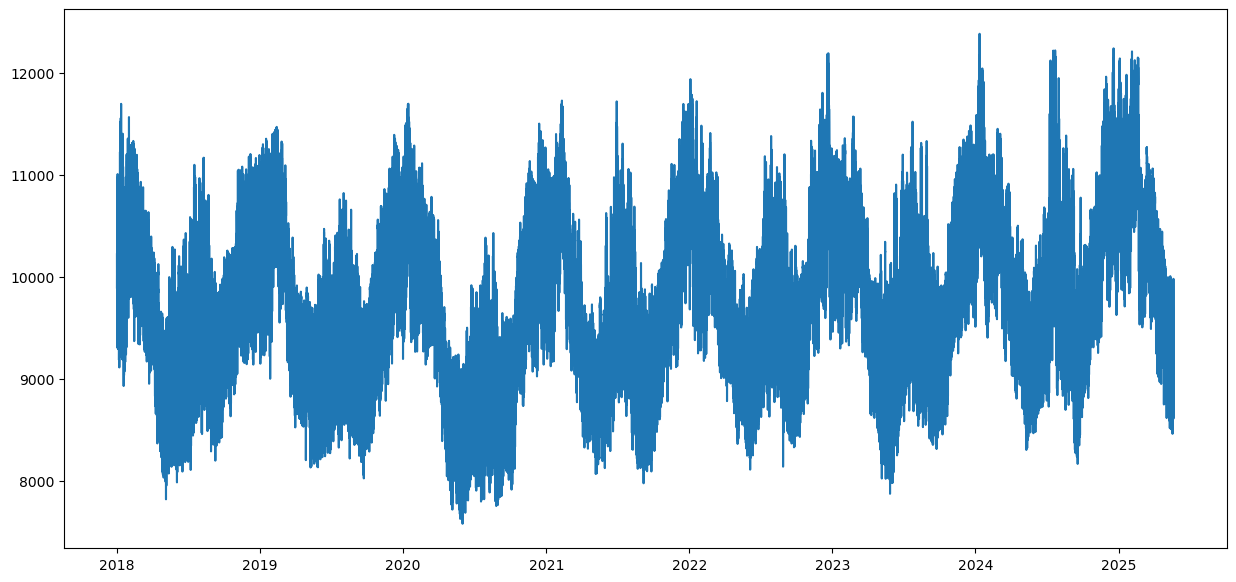

In [12]:
#Demand trend
plt.figure(figsize=(15, 7))
plt.plot(demand['timestamp'], demand['system_demand'], label='Demand')

In [13]:
#Add other date related features to temp_data
temp_data['month'] = temp_data.index.month
temp_data['year'] = temp_data.index.year
temp_data['dayofyear'] = temp_data.index.dayofyear
temp_data['weekofyear'] = temp_data.index.isocalendar().week.astype(int)
temp_data['is_weekend'] = temp_data.index.dayofweek >= 5
temp_data['hour'] = temp_data.index.hour
temp_data['dayofweek'] = temp_data.index.dayofweek  # Monday=0, Sunday=6

# Peak: Mon–Sat, 7:00–22:59
temp_data['is_peak'] = temp_data.apply(lambda row: (row['dayofweek'] < 6) and (7 <= row['hour'] < 23), axis=1)
temp_data.head()

,CYEG_temp,CYYC_temp,Avg_temp,HDH,CDH,month,year,dayofyear,weekofyear,is_weekend,hour,dayofweek,is_peak
timestamp,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,-28.1,-28.1,-28.10,46.10,0.0,1,2018,1,1,False,0,0,False
2018-01-01 01:00:00+00:00,-28.3,-28.6,-28.45,46.45,0.0,1,2018,1,1,False,1,0,False
2018-01-01 02:00:00+00:00,-28.7,-29.1,-28.90,46.90,0.0,1,2018,1,1,False,2,0,False
2018-01-01 03:00:00+00:00,-28.5,-30.0,-29.25,47.25,0.0,1,2018,1,1,False,3,0,False
2018-01-01 04:00:00+00:00,-28.3,-27.6,-27.95,45.95,0.0,1,2018,1,1,False,4,0,False


In [14]:
last_timestamp = temp_data.index.max()

# Create timestamps for the next year (long-term)
future_timestamps_long_term = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=365 * 24, freq='h')
future_data_long_term = pd.DataFrame(index=future_timestamps_long_term)
print("\nFuture timestamps for long-term forecast (first 5):")
display(future_timestamps_long_term[:5])

display(future_data_long_term.tail())


Future timestamps for long-term forecast (first 5):


DatetimeIndex(['2025-05-21 08:00:00+00:00', '2025-05-21 09:00:00+00:00',
               '2025-05-21 10:00:00+00:00', '2025-05-21 11:00:00+00:00',
               '2025-05-21 12:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='h')

""
2026-05-21 03:00:00+00:00
2026-05-21 04:00:00+00:00
2026-05-21 05:00:00+00:00
2026-05-21 06:00:00+00:00
2026-05-21 07:00:00+00:00


In [15]:
#add date related features in future df
future_data_long_term['month'] = future_data_long_term.index.month
future_data_long_term['year'] = future_data_long_term.index.year
future_data_long_term['dayofyear'] = future_data_long_term.index.dayofyear
future_data_long_term['weekofyear'] = future_data_long_term.index.isocalendar().week.astype(int)
future_data_long_term['is_weekend'] = future_data_long_term.index.dayofweek >= 5
future_data_long_term['hour'] = future_data_long_term.index.hour
future_data_long_term['dayofweek'] = future_data_long_term.index.dayofweek  # Monday=0, Sunday=6

# Peak: Mon–Sat, 7:00–22:59
future_data_long_term['is_peak'] = future_data_long_term.apply(lambda row: (row['dayofweek'] < 6) and (7 <= row['hour'] < 23), axis=1)
future_data_long_term.head()

,month,year,dayofyear,weekofyear,is_weekend,hour,dayofweek,is_peak
2025-05-21 08:00:00+00:00,5,2025,141,21,False,8,2,True
2025-05-21 09:00:00+00:00,5,2025,141,21,False,9,2,True
2025-05-21 10:00:00+00:00,5,2025,141,21,False,10,2,True
2025-05-21 11:00:00+00:00,5,2025,141,21,False,11,2,True
2025-05-21 12:00:00+00:00,5,2025,141,21,False,12,2,True


In [16]:
## Add Temperature related features in the future df
# Select the 'Avg_temp' column
avg_temp = temp_data[['Avg_temp']]
# Extract hour of the day and day of the year from the index and create new columns
avg_temp['hour'] = avg_temp.index.hour
avg_temp['dayofyear'] = avg_temp.index.dayofyear

# Group the data by 'dayofyear' and 'hour' and calculate the mean 'Avg_temp'
average_hourly_yearly_temp = avg_temp.groupby(['dayofyear', 'hour'])['Avg_temp'].mean().reset_index()

# Merge this average hourly yearly temperature data into the future_data_long_term DataFrame
# Create temporary 'dayofyear' and 'hour' columns in the future dataframes, merge, and then drop the temporary columns
future_data_long_term = future_data_long_term.reset_index().merge(average_hourly_yearly_temp, on=['dayofyear', 'hour'], how='left')
future_data_long_term = future_data_long_term.rename(columns={'index': 'timestamp'}).set_index('timestamp')

# If Avg_temp is below base_temperature, calculate the difference, otherwise 0
future_data_long_term['HDH'] = np.maximum(0, base_temperature - future_data_long_term['Avg_temp'])

# Calculate Cooling Degree Hours (CDH)
# If Avg_temp is above base_temperature, calculate the difference, otherwise 0
future_data_long_term['CDH'] = np.maximum(0, future_data_long_term['Avg_temp'] - base_temperature)

future_data_long_term.head()

C:\Users\cb44a\AppData\Local\Temp\ipykernel_9008\1900025903.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_temp['hour'] = avg_temp.index.hour
C:\Users\cb44a\AppData\Local\Temp\ipykernel_9008\1900025903.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_temp['dayofyear'] = avg_temp.index.dayofyear


,month,year,dayofyear,weekofyear,is_weekend,hour,dayofweek,is_peak,Avg_temp,HDH,CDH
timestamp,,,,,,,,,,,
2025-05-21 08:00:00+00:00,5,2025,141,21,False,8,2,True,10.178571,7.821429,0.0
2025-05-21 09:00:00+00:00,5,2025,141,21,False,9,2,True,11.285714,6.714286,0.0
2025-05-21 10:00:00+00:00,5,2025,141,21,False,10,2,True,12.128571,5.871429,0.0
2025-05-21 11:00:00+00:00,5,2025,141,21,False,11,2,True,12.750000,5.250000,0.0
2025-05-21 12:00:00+00:00,5,2025,141,21,False,12,2,True,13.471429,4.528571,0.0


In [17]:
#add population data in historical data
demand_feat_df=temp_data.reset_index().merge(population_df, on='year', how='left')

In [18]:
#add population data in future data
future_data=future_data_long_term.reset_index().merge(population_df, on='year', how='left')

In [19]:
pip install holidays


   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 19.7 MB/s eta 0:00:00


In [20]:
import holidays
# Get Alberta holidays from 2018 to 2026
ab_holidays = holidays.CA(prov='AB', years=range(2018, 2027))

holiday_df = pd.DataFrame(ab_holidays.items(), columns=['date', 'holiday_name'])
holiday_df['date'] = pd.to_datetime(holiday_df['date'])
holiday_df.head()

,date,holiday_name
0,2018-01-01,New Year's Day
1,2018-03-30,Good Friday
2,2018-07-01,Canada Day
3,2018-09-03,Labour Day
4,2018-12-25,Christmas Day


In [21]:
#add holiday as feature in historical data
demand_feat_df['is_holiday'] = demand_feat_df['timestamp'].dt.date.isin(holiday_df['date'].dt.date)

In [22]:
#add holiday as feature in future data
future_data['is_holiday'] = future_data['timestamp'].dt.date.isin(holiday_df['date'].dt.date)

In [23]:
#quick glimpse of historical data and future data
display(demand_feat_df.head())
display(future_data.head())

,timestamp,CYEG_temp,CYYC_temp,Avg_temp,HDH,CDH,month,year,dayofyear,weekofyear,is_weekend,hour,dayofweek,is_peak,Population_Millions,is_holiday
0,2018-01-01 00:00:00+00:00,-28.1,-28.1,-28.10,46.10,0.0,1,2018,1,1,False,0,0,False,4.33,True
1,2018-01-01 01:00:00+00:00,-28.3,-28.6,-28.45,46.45,0.0,1,2018,1,1,False,1,0,False,4.33,True
2,2018-01-01 02:00:00+00:00,-28.7,-29.1,-28.90,46.90,0.0,1,2018,1,1,False,2,0,False,4.33,True
3,2018-01-01 03:00:00+00:00,-28.5,-30.0,-29.25,47.25,0.0,1,2018,1,1,False,3,0,False,4.33,True
4,2018-01-01 04:00:00+00:00,-28.3,-27.6,-27.95,45.95,0.0,1,2018,1,1,False,4,0,False,4.33,True


,timestamp,month,year,dayofyear,weekofyear,is_weekend,hour,dayofweek,is_peak,Avg_temp,HDH,CDH,Population_Millions,is_holiday
0,2025-05-21 08:00:00+00:00,5,2025,141,21,False,8,2,True,10.178571,7.821429,0.0,5.07,False
1,2025-05-21 09:00:00+00:00,5,2025,141,21,False,9,2,True,11.285714,6.714286,0.0,5.07,False
2,2025-05-21 10:00:00+00:00,5,2025,141,21,False,10,2,True,12.128571,5.871429,0.0,5.07,False
3,2025-05-21 11:00:00+00:00,5,2025,141,21,False,11,2,True,12.750000,5.250000,0.0,5.07,False
4,2025-05-21 12:00:00+00:00,5,2025,141,21,False,12,2,True,13.471429,4.528571,0.0,5.07,False


In [24]:
#no need of city based temp since they can introduce colinearity
demand_feat_df.drop(['CYEG_temp', 'CYYC_temp'], axis=1, inplace=True)

In [34]:
demand_df = pd.merge(demand_feat_df, demand, on='timestamp', how='left')
demand_df.head()

,timestamp,Avg_temp,HDH,CDH,month,year,dayofyear,weekofyear,is_weekend,hour,dayofweek,is_peak,Population_Millions,is_holiday,system_demand
0,2018-01-01 00:00:00+00:00,-28.10,46.10,0.0,1,2018,1,1,False,0,0,False,4.33,True,10221.0
1,2018-01-01 01:00:00+00:00,-28.45,46.45,0.0,1,2018,1,1,False,1,0,False,4.33,True,10082.0
2,2018-01-01 02:00:00+00:00,-28.90,46.90,0.0,1,2018,1,1,False,2,0,False,4.33,True,9949.0
3,2018-01-01 03:00:00+00:00,-29.25,47.25,0.0,1,2018,1,1,False,3,0,False,4.33,True,9886.0
4,2018-01-01 04:00:00+00:00,-27.95,45.95,0.0,1,2018,1,1,False,4,0,False,4.33,True,9930.0


In [35]:
#look for missing data
demand_df.isnull().sum()

timestamp               0
Avg_temp                0
HDH                     0
CDH                     0
month                   0
year                    0
dayofyear               0
weekofyear              0
is_weekend              0
hour                    0
dayofweek               0
is_peak                 0
Population_Millions     0
is_holiday              0
system_demand          21
dtype: int64

In [37]:
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64743 entries, 0 to 64742
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   timestamp            64743 non-null  datetime64[ns, UTC]
 1   Avg_temp             64743 non-null  float64            
 2   HDH                  64743 non-null  float64            
 3   CDH                  64743 non-null  float64            
 4   month                64743 non-null  int32              
 5   year                 64743 non-null  int32              
 6   dayofyear            64743 non-null  int32              
 7   weekofyear           64743 non-null  int64              
 8   is_weekend           64743 non-null  bool               
 9   hour                 64743 non-null  int32              
 10  dayofweek            64743 non-null  int32              
 11  is_peak              64743 non-null  bool               
 12  Population_Million

In [38]:
# interpolate missing demand and price
demand_df['timestamp'] = pd.to_datetime(demand_df['timestamp'])
demand_df= demand_df.sort_values('timestamp')
demand_df.set_index('timestamp', inplace=True)
demand_df['system_demand'] = demand_df ['system_demand'].interpolate(method='time')

In [39]:
# Create lagged demand features
for i in range(1, 25):
    demand_df[f'demand_lag_{i}'] = demand_df['system_demand'].shift(i)

for i in [24 * 7, 24 * 14]: # Add weekly and bi-weekly lags
     demand_df[f'demand_lag_{i}'] = demand_df['system_demand'].shift(i)

In [42]:
demand_df_final=demand_df.copy()

In [43]:
# Define the target variable
target = 'system_demand'

# Define features (all columns except the target and the timestamp index)
features = [col for col in demand_df_final.columns if col != target and col != demand_df_final.index.name]

X = demand_df_final[features]
y = demand_df_final[target]

# Determine the split point (80% for training, 20% for testing)
train_split_index = int(len(demand_df_final) * 0.8)

# Perform the chronological split
X_train, X_test = X[:train_split_index], X[train_split_index:]
y_train, y_test = y[:train_split_index], y[train_split_index:]

print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shape (X_test, y_test):", X_test.shape, y_test.shape)

Training set shape (X_train, y_train): (51794, 39) (51794,)
Testing set shape (X_test, y_test): (12949, 39) (12949,)


In [44]:
# Initialize and train the XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=50, random_state=42)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [45]:
# Make predictions on the train set
y_train_pred = xgb_model.predict(X_train)

# Evaluate the model using MAE and RMSE
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"Training set Mean Absolute Error (MAE): {train_mae:.2f}")
print(f"Training set Root Mean Squared Error (RMSE): {train_rmse:.2f}")

Training set Mean Absolute Error (MAE): 29.86
Training set Root Mean Squared Error (RMSE): 38.91


In [47]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model using MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 47.45
Root Mean Squared Error (RMSE): 66.98


In [52]:
import joblib
joblib.dump(xgb_model, '../outputs/demand_model.joblib')

['../outputs/demand_model.joblib']

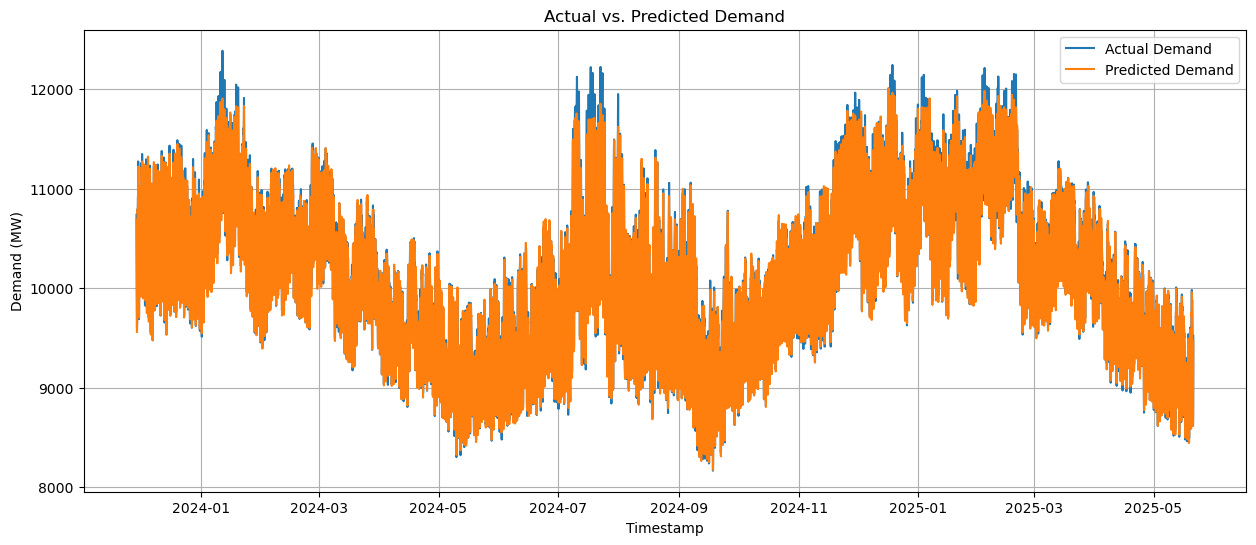

In [48]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual Demand')
plt.plot(y_test.index, y_pred, label='Predicted Demand')
plt.xlabel('Timestamp')
plt.ylabel('Demand (MW)')
plt.title('Actual vs. Predicted Demand')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
future_data=future_data.set_index('timestamp')
future_data.head()

,month,year,dayofyear,weekofyear,is_weekend,hour,dayofweek,is_peak,Avg_temp,HDH,CDH,Population_Millions,is_holiday
timestamp,,,,,,,,,,,,,
2025-05-21 08:00:00+00:00,5,2025,141,21,False,8,2,True,10.178571,7.821429,0.0,5.07,False
2025-05-21 09:00:00+00:00,5,2025,141,21,False,9,2,True,11.285714,6.714286,0.0,5.07,False
2025-05-21 10:00:00+00:00,5,2025,141,21,False,10,2,True,12.128571,5.871429,0.0,5.07,False
2025-05-21 11:00:00+00:00,5,2025,141,21,False,11,2,True,12.750000,5.250000,0.0,5.07,False
2025-05-21 12:00:00+00:00,5,2025,141,21,False,12,2,True,13.471429,4.528571,0.0,5.07,False


In [50]:
# Generate lagged demand features for the one-year forecast (iterative forecasting)
lags_to_include = [f'demand_lag_{i}' for i in range(1, 25)] + ['demand_lag_168', 'demand_lag_336']

# Create a temporary dataframe to store predictions and use for lags
one_year_forecast_df = future_data.copy() # Start with the dataframe containing all the features
one_year_forecast_df['system_demand_predicted'] = np.nan

# Get the last few actual demand values from the historical data to initialize lags
max_lag = 336
last_demand_values = demand_df_final['system_demand'].iloc[-max_lag:]
initial_lags = last_demand_values.tolist()


for i in range(len(one_year_forecast_df)):
    # Get the current timestamp and features
    current_timestamp = one_year_forecast_df.index[i]
    current_features = one_year_forecast_df.iloc[i].copy()

    # Fill in the lagged demand values
    for lag_col in lags_to_include:
        lag_period = int(lag_col.split('_')[-1])
        if i - lag_period >= 0:
            # Use predicted demand from previous steps for lags within the forecast horizon
            current_features[lag_col] = one_year_forecast_df['system_demand_predicted'].iloc[i - lag_period]
        else:
             # Calculate the index in the initial_lags list
            initial_lag_index = len(initial_lags) - (lag_period - i)
            if 0 <= initial_lag_index < len(initial_lags):
                current_features[lag_col] = initial_lags[initial_lag_index]
            else:
                # Handle cases where the lag period is beyond the available historical data
                current_features[lag_col] = np.nan # Or some other appropriate value



    # Ensure the order of columns matches the training data
    current_features = current_features[X_train.columns]

    # Reshape for prediction
    current_features_reshaped = current_features.values.reshape(1, -1)

    # Predict demand for the current timestamp using the XGBoost model
    predicted_demand = xgb_model.predict(current_features_reshaped)[0]

    # Store the prediction
    one_year_forecast_df.loc[current_timestamp, 'system_demand_predicted'] = predicted_demand

print("One-year forecast data (head):")
display(one_year_forecast_df.head())

print("\nOne-year forecast data (tail):")
display(one_year_forecast_df.tail())

One-year forecast data (head):


,month,year,dayofyear,weekofyear,is_weekend,hour,dayofweek,is_peak,Avg_temp,HDH,CDH,Population_Millions,is_holiday,system_demand_predicted
timestamp,,,,,,,,,,,,,,
2025-05-21 08:00:00+00:00,5,2025,141,21,False,8,2,True,10.178571,7.821429,0.0,5.07,False,9657.991211
2025-05-21 09:00:00+00:00,5,2025,141,21,False,9,2,True,11.285714,6.714286,0.0,5.07,False,9742.618164
2025-05-21 10:00:00+00:00,5,2025,141,21,False,10,2,True,12.128571,5.871429,0.0,5.07,False,9795.672852
2025-05-21 11:00:00+00:00,5,2025,141,21,False,11,2,True,12.750000,5.250000,0.0,5.07,False,9790.685547
2025-05-21 12:00:00+00:00,5,2025,141,21,False,12,2,True,13.471429,4.528571,0.0,5.07,False,9776.211914



One-year forecast data (tail):


,month,year,dayofyear,weekofyear,is_weekend,hour,dayofweek,is_peak,Avg_temp,HDH,CDH,Population_Millions,is_holiday,system_demand_predicted
timestamp,,,,,,,,,,,,,,
2026-05-21 03:00:00+00:00,5,2026,141,21,False,3,3,False,5.53125,12.46875,0.0,5.19,False,7956.147461
2026-05-21 04:00:00+00:00,5,2026,141,21,False,4,3,False,5.32500,12.67500,0.0,5.19,False,8022.774902
2026-05-21 05:00:00+00:00,5,2026,141,21,False,5,3,False,5.05625,12.94375,0.0,5.19,False,8069.784180
2026-05-21 06:00:00+00:00,5,2026,141,21,False,6,3,False,6.23750,11.76250,0.0,5.19,False,8283.999023
2026-05-21 07:00:00+00:00,5,2026,141,21,False,7,3,True,8.02500,9.97500,0.0,5.19,False,8620.873047


In [55]:
forecast=one_year_forecast_df[['Avg_temp', 'system_demand_predicted']]
forecast.rename({'Avg_temp': 'Average Temperature', 'system_demand_predicted': 'Forecasted Power Demand'}, axis=1, inplace=True)
# Save forecast to CSV
forecast.to_csv('../outputs/forecast.csv')

C:\Users\cb44a\AppData\Local\Temp\ipykernel_9008\2723614515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast.rename({'Avg_temp': 'Average Temperature', 'system_demand_predicted': 'Forecasted Power Demand'}, axis=1, inplace=True)


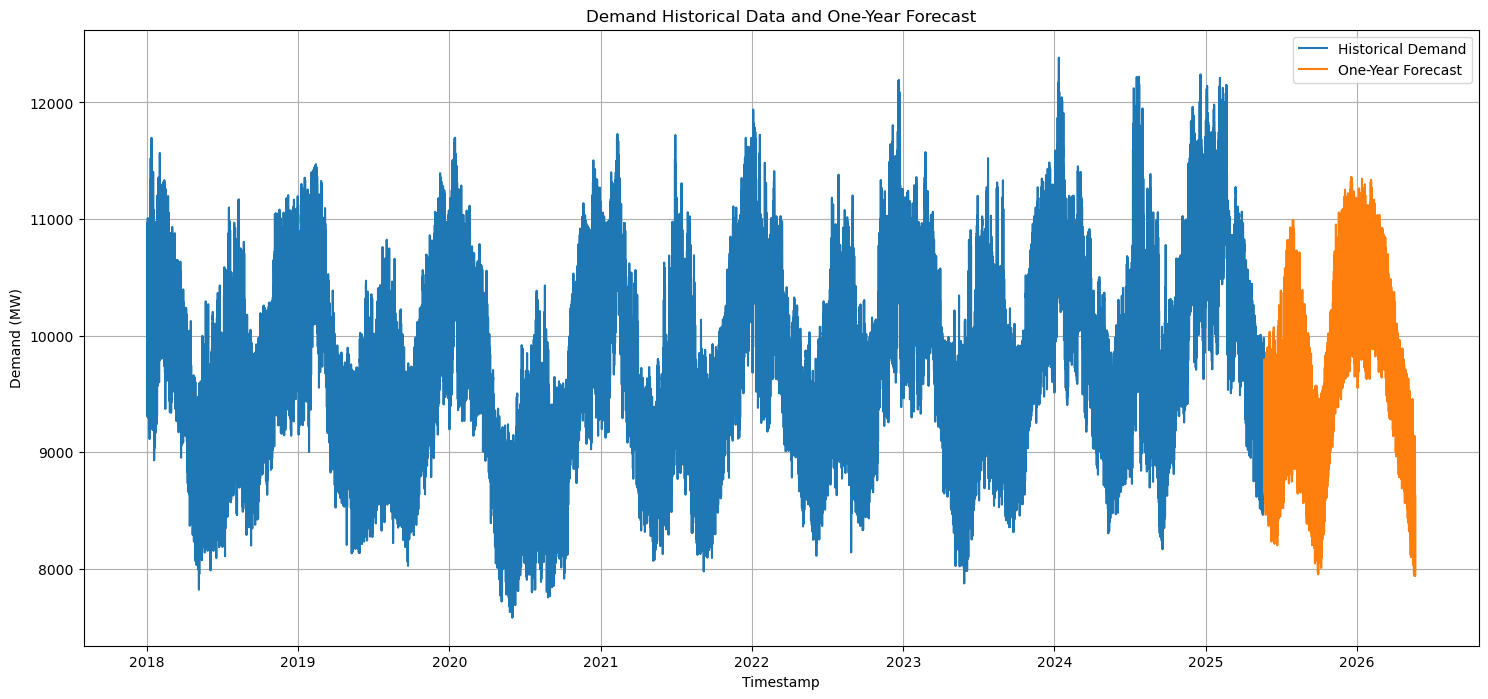

In [51]:
#plot to see the forecast to future for next one year hourly
plt.figure(figsize=(18, 8))
plt.plot(demand_df_final.index, demand_df_final['system_demand'], label='Historical Demand')
plt.plot(one_year_forecast_df.index, one_year_forecast_df['system_demand_predicted'], label='One-Year Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Demand (MW)')
plt.title('Demand Historical Data and One-Year Forecast')
plt.legend()
plt.grid(True)
plt.show()